In [1]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from tqdm import tqdm
from functions import ANALYSIS
from architecture import ARCHITECTURE
import architecture

from collections import Counter
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.models import load_model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Concatenate, Layer
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D, LSTM, CuDNNLSTM

import keras.backend as K
import keras

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

EXP = 'CD101T10'

obj = ANALYSIS(EXP)
arch_obj = ARCHITECTURE()

Using TensorFlow backend.


In [2]:
P = pd.read_csv('data/ProtSeqForModel.csv')
D = pd.read_csv('data/DrugSeqForModel.csv')
des_drug = np.load('data/DrugDesForModel.npy')
drug_smiles=pd.read_csv('data/drug_smiles.csv')[['drug','smile','seq_char_count']]
DTI_index=pd.read_csv('data/DTI_index.csv')[['target','drug','IC50','unit','activity','target_uniprot']]

In [3]:
# Encode amino acides and smile characters
codes_target = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
char_dict_target = obj.create_dict(codes_target)

codes_drug = [char for char in ''.join(set(''.join(drug_smiles['smile'].values)))]
char_dict_drug = obj.create_dict(codes_drug)

encode_target = obj.integer_encoding(P, char_dict_target) 
encode_drug = obj.integer_encoding(D, char_dict_drug) 

# padding sequences
max_length = 1000
pad_target = pad_sequences(encode_target, maxlen=max_length, padding='post', truncating='post')
pad_drug = pad_sequences(encode_drug, maxlen=max_length, padding='post', truncating='post')

# One hot encoding of sequences
# ohe_target = to_categorical(pad_target)
# ohe_drug = to_categorical(pad_drug)
# ohe_target.shape, ohe_drug.shape

# label/integer encoding output variable: (y)
le = LabelEncoder()
y = le.fit_transform(DTI_index['activity'].tolist())
# One hot encoding of outputs
y = to_categorical(y)

In [6]:
# Define architecture
input_target, att_out_target = arch_obj.protSeq(1000)
input_drug, att_out_drug = arch_obj.drugSeq(1000)
input_drug_des, dense_drug_des_2 = arch_obj.drugDes(111)

concat = Concatenate()([att_out_target,att_out_drug, dense_drug_des_2])

dense_1 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(concat)
#dense_1_dropout = Dropout(0.1)(dense_1)
#dense_2 = Dense(256, activation = 'relu',kernel_initializer='glorot_normal')(dense_1)
dense_2 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(dense_1)
dense_2_dropout = Dropout(0.2)(dense_2)

x_output = Dense(3, activation='softmax')(dense_2_dropout)

# Bulid and compile model
model1 = Model(inputs=[input_target, input_drug, input_drug_des], outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model1.summary()

In [4]:
# Split indics into train/test
from sklearn.model_selection import train_test_split
indices = list(range(len(DTI_index)))
train_target, test_target, train_drug, test_drug, train_des, test_des, y_train, y_test = train_test_split(pad_target, pad_drug, des_drug, y, test_size=0.2, random_state=20)

print(train_target.shape, test_target.shape, train_drug.shape, test_drug.shape)

(49299, 1000) (12325, 1000) (49299, 1000) (12325, 1000)


In [11]:
# Early Stopping & checkpoint
es = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
filepath='checkpoints/'+EXP+'/improvement_'+EXP+'.hdf5'
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
histories = []

history = model1.fit(
    [train_target, train_drug, train_des], y_train,
    epochs=500, batch_size=256,
    validation_split=0.2,
    callbacks=[es, model_checkpoint]
    )

39439 [==============================] - 18s 459us/step - loss: 0.6416 - accuracy: 0.7377 - val_loss: 0.6998 - val_accuracy: 0.7163

Epoch 00161: val_loss improved from 0.70234 to 0.69977, saving model to checkpoints/CD101T10/improvement_CD101T10.hdf5
Epoch 162/500
39439/39439 [==============================] - 18s 457us/step - loss: 0.6371 - accuracy: 0.7408 - val_loss: 0.7133 - val_accuracy: 0.7126

Epoch 00162: val_loss did not improve from 0.69977
Epoch 163/500
39439/39439 [==============================] - 18s 459us/step - loss: 0.6339 - accuracy: 0.7411 - val_loss: 0.7629 - val_accuracy: 0.6907

Epoch 00163: val_loss did not improve from 0.69977
Epoch 164/500
39439/39439 [==============================] - 18s 458us/step - loss: 0.6367 - accuracy: 0.7416 - val_loss: 0.7286 - val_accuracy: 0.7072

Epoch 00164: val_loss did not improve from 0.69977
Epoch 165/500
39439/39439 [==============================] - 18s 458us/step - loss: 0.6327 - accuracy: 0.7426 - val_loss: 0.6979 - val_a

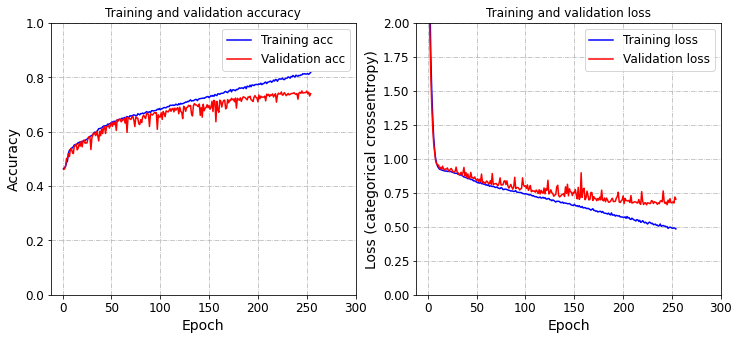

In [24]:
obj.plotTrainingPerf(history, save=False)

In [5]:
# Load saved model
saved_model = load_model('checkpoints/'+EXP+'/improvement_'+EXP+'.hdf5', custom_objects={'attention': architecture.attention})

In [8]:
# Load saved model
saved_model = load_model('checkpoints/CD101T10/improvement_.hdf5', custom_objects={'attention': architecture.attention})

In [9]:
# Calculate ROC and PR characteristics
roc_auc, fpr, tpr = obj.roc(saved_model, y_test, a = test_target, b = test_drug, c = test_des)
precision, recall, average_precision = obj.aupr(saved_model, y_test, a = test_target, b = test_drug, c = test_des)

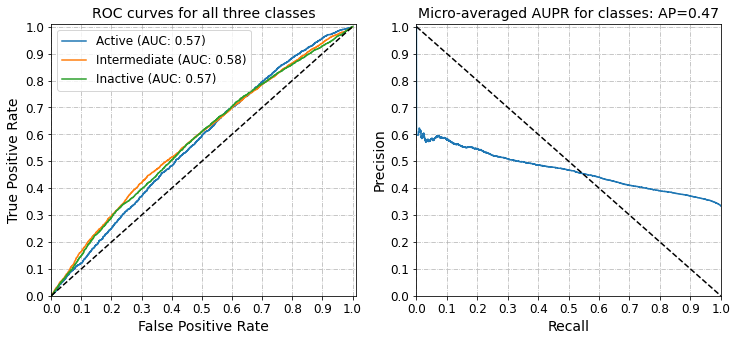

In [10]:
# Plot ROC/PR curve
obj.plotROC_PR(fpr, tpr, roc_auc, precision, recall, average_precision, save=False)

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model1.evaluate([test_pad_target, test_pad_drug], y_test, batch_size=256)
print("test loss, test acc:", results)

In [ ]:
# EXTERNAL VALIDATION